### 📌 Challenge Posos - Classification d'intentions NLP

In [1]:
# =====================
# 📦 IMPORTS & SETUP
# =====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack


In [2]:
# ========== 🔧 INIT ========== #
nltk.download('stopwords')
nltk.download('punkt')
!python -m spacy download fr_core_news_sm

nlp = spacy.load("fr_core_news_sm")
stop_words = set(stopwords.words('french'))

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.8.0/fr_core_news_sm-3.8.0-py3-none-any.whl (16.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [3]:
import os
print(os.listdir("../data/"))  # Liste les fichiers dans le dossier data

['output_train.csv', 'output', 'input_test.csv', 'input_train.csv']


In [4]:
# =====================
# 📁 1. CHARGEMENT
# =====================
path_train = "../data/input_train.csv"
path_labels = "../data/output_train.csv"
path_test = "../data/input_test.csv"

df_train = pd.read_csv(path_train)
df_labels = pd.read_csv(path_labels)
df_test = pd.read_csv(path_test)
df_train = df_train.merge(df_labels, on="ID")
df_train.dropna(subset=["question"], inplace=True)
df_test.dropna(subset=["question"], inplace=True)

In [5]:
df_train.head()

,ID,question,intention
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28
1,1,est ce que le motilium me soulagera contre les...,31
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44
4,4,mon medecin me soigne pour une rhino pha...,31


In [6]:
df_train['intention'].value_counts()

intention
28    1796
31     565
44     560
22     461
48     387
34     382
32     321
14     317
42     315
23     208
0      204
11     195
21     180
33     144
8      134
37     126
38     120
13     119
27     104
5      102
43      91
12      89
47      82
29      77
4       76
26      72
10      68
24      64
9       54
30      52
45      50
35      50
41      45
46      45
39      40
50      33
25      30
6       26
36      25
1       23
18      23
15      23
49      22
2       22
7       20
19      20
20      19
16      17
17      15
3        8
40       7
Name: count, dtype: int64

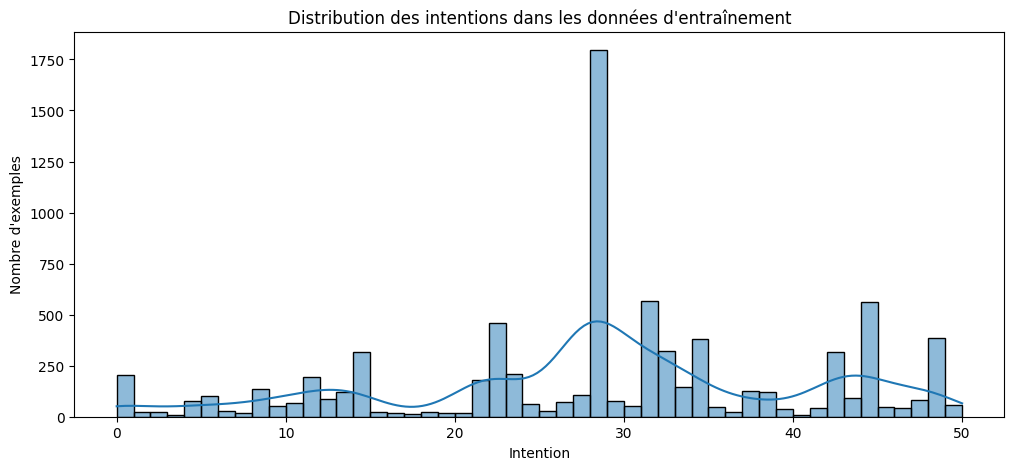

In [7]:
plt.figure(figsize=(12,5))
sns.histplot(df_train['intention'], bins=50, kde=True)
plt.title("Distribution des intentions dans les données d'entraînement")
plt.xlabel("Intention")
plt.ylabel("Nombre d'exemples")
plt.show()

In [8]:
# =====================
# 🧼 2. PREPROCESSING
# =====================
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-ZÀ-ÿ0-9]", " ", text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words]
    return " ".join(tokens)

df_train["clean_text"] = df_train["question"].apply(preprocess_text)
df_test["clean_text"] = df_test["question"].apply(preprocess_text)


df_train[["question", "clean_text"]].head()

,question,clean_text
0,"bonjour, je m suis trompé de forum pour ma qu...",bonjour tromper forum question alors repose...
1,est ce que le motilium me soulagera contre les...,motilium soulager contre nausée
2,mon médecin m'a prescrit adenyl. au 2ème cache...,médecin avoir prescrire adenyl 2ème cachet m...
3,Est-ce qu'il existe une forme adaptée aux enfa...,exister forme adapter enfant 5ans micropakine
4,mon medecin me soigne pour une rhino pha...,medecin soigner rhino pharingite ...


In [14]:
# =====================
# 🏷️ 3. ENCODAGE LABELS
# =====================
encodeur = LabelEncoder()
df_train["intention_labellisee"] = encodeur.fit_transform(df_train["intention"])


In [10]:
from gensim.models import Word2Vec

sentences = [text.split() for text in df_train["clean_text"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=20)

def vectoriser_moyenne(text, model):
    tokens = text.split()
    vecteurs = [model.wv[token] for token in tokens if token in model.wv]
    if len(vecteurs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecteurs, axis=0)

X_train_vec = np.vstack(df_train["clean_text"].apply(lambda x: vectoriser_moyenne(x, w2v_model)))
X_test_vec = np.vstack(df_test["clean_text"].apply(lambda x: vectoriser_moyenne(x, w2v_model)))

In [11]:
# =====================
# 📊 5. TF-IDF VECTORIZATION
# =====================
vectoriseur = TfidfVectorizer(
    max_features=12000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    strip_accents="unicode",
    norm="l2"
)
X_tfidf = vectoriseur.fit_transform(df_train["clean_text"]).toarray()
X_test_tfidf = vectoriseur.transform(df_test["clean_text"]).toarray()

In [12]:
def extraire_features_textuelles(texte):
    return [
        len(texte),
        sum(1 for c in texte if c.isupper()),
        sum(1 for c in texte if c in ".?!"),
    ]

X_train_feats = np.vstack(df_train["question"].apply(extraire_features_textuelles))
X_test_feats = np.vstack(df_test["question"].apply(extraire_features_textuelles))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_full = np.hstack([X_tfidf, X_train_vec, scaler.fit_transform(X_train_feats)])
X_test_full = np.hstack([X_test_tfidf, X_test_vec, scaler.transform(X_test_feats)])

In [15]:
# =====================
# ✂️ 6. SPLIT VALIDATION
# =====================
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    df_train["intention_labellisee"],
    test_size=0.2,
    stratify=df_train["intention_labellisee"],
    random_state=42
)

In [16]:
# =====================
# 🤖 7. RIDGE CLASSIFIER
# =====================

# Grille des hyperparamètres à tester
param_grid = {
    "alpha": [0.01, 0.1, 1.0, 10.0],
    "class_weight": [None, "balanced"]
}

# GridSearch avec validation croisée
grid_ridge = GridSearchCV(
    RidgeClassifier(),
    param_grid,
    scoring="f1_weighted",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entraînement du meilleur modèle
grid_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=RidgeClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0],
                         'class_weight': [None, 'balanced']},
             scoring='f1_weighted', verbose=1)

In [ ]:
# print("✅ Meilleurs paramètres trouvés :")
# for cle, valeur in etude.best_params.items():
#     print(f"- {cle} : {valeur}")

# print(f"\n🏆 Meilleur F1-score (validation croisée) : {etude.best_value:.4f}")

In [17]:
# Prédictions validation
preds_val = grid_ridge.predict(X_val)

# Évaluation
acc = accuracy_score(y_val, preds_val)
f1 = f1_score(y_val, preds_val, average="weighted")

print("✅ Meilleurs hyperparamètres :")
print(grid_ridge.best_params_)
print(f"\n✅ Accuracy (validation) : {acc:.4f}")
print(f"✅ F1-score pondéré : {f1:.4f}")
print("\n📝 Rapport complet :\n")
print(classification_report(y_val, preds_val))

✅ Meilleurs hyperparamètres :
{'alpha': 1.0, 'class_weight': None}

✅ Accuracy (validation) : 0.6650
✅ F1-score pondéré : 0.6483

📝 Rapport complet :

              precision    recall  f1-score   support

           0       0.95      0.51      0.67        41
           1       0.50      0.20      0.29         5
           2       0.50      0.50      0.50         4
           3       1.00      0.50      0.67         2
           4       0.60      0.40      0.48        15
           5       0.68      0.65      0.67        20
           6       1.00      0.20      0.33         5
           7       0.33      0.25      0.29         4
           8       0.66      0.78      0.71        27
           9       0.50      0.36      0.42        11
          10       0.64      0.50      0.56        14
          11       0.57      0.31      0.40        39
          12       0.00      0.00      0.00        18
          13       0.70      0.88      0.78        24
          14       0.49      0.49     

/Users/bethuelasse/Documents/MASTER_MOSEF/DEEP LEARNING NLP/PROJET/.nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bethuelasse/Documents/MASTER_MOSEF/DEEP LEARNING NLP/PROJET/.nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bethuelasse/Documents/MASTER_MOSEF/DEEP LEARNING NLP/PROJET/.nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

In [18]:
import os
from datetime import datetime

# Dossier output
dossier_output = "../data/output"
os.makedirs(dossier_output, exist_ok=True)

# Horodatage
horodatage = datetime.now().strftime("%Y-%m-%d_%H-%M")

# Noms de fichiers
nom_csv = f"y_test_ridge_{horodatage}.csv"
nom_txt = f"y_test_ridge_{horodatage}_params.txt"
chemin_csv = os.path.join(dossier_output, nom_csv)
chemin_txt = os.path.join(dossier_output, nom_txt)

# Prédictions test
preds_test = grid_ridge.predict(X_test_full)
preds_test_decode = encodeur.inverse_transform(preds_test)

# Export CSV
df_ridge = pd.DataFrame({
    "ID": df_test["ID"],
    "intention": preds_test_decode
})
df_ridge.to_csv(chemin_csv, index=False)

# Export TXT résumé
with open(chemin_txt, "w") as f:
    f.write(f"Soumission RidgeClassifier optimisée\nDate : {horodatage}\n\n")
    f.write("Meilleurs paramètres :\n")
    for k, v in grid_ridge.best_params_.items():
        f.write(f"- {k} : {v}\n")
    f.write(f"\nScores sur validation :\n")
    f.write(f"- Accuracy : {acc:.4f}\n")
    f.write(f"- F1-score pondéré : {f1:.4f}\n")

print(f"\n📦 Fichier CSV exporté : {chemin_csv}")
print(f"📄 Paramètres sauvegardés dans : {chemin_txt}")


📦 Fichier CSV exporté : ../data/output/y_test_ridge_2025-04-20_14-06.csv
📄 Paramètres sauvegardés dans : ../data/output/y_test_ridge_2025-04-20_14-06_params.txt
